In [1]:
# Google Colab

google_colab = False
if google_colab:
    # !pip install emoji
    import nltk
    nltk.download('punkt')
    nltk.download('stopwords')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji # for demojize
import re # for regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer # for Pipeline
from sklearn.naive_bayes import MultinomialNB
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW, Adam
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# 1 - Analysis of the dataset

#### 1.1 - Loading the  dataset

In [3]:
df = pd.read_csv("content/Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.shape

(14640, 15)

So, the dataset contains 14640 entries and has 15 columns. The ones that we are interested in are "airline_sentiment" and "text". It represents the sentiment felt by the author of the tweet about US Airlines, 3 possible cases : positive, neutral, negative. At first glance, I don't think that the other columns are relevant in our project as we don't want the model to overfit on for instance Twitter's username or airline.

#### 1.2 - Removing duplications

In [5]:
df[df.duplicated(subset=["tweet_id"], keep=False)].sort_values(by="tweet_id")

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12033,569600137296633856,positive,0.9236,NaN,0.0000,American,positive,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14556,569600137296633856,positive,1.0000,NaN,NaN,American,NaN,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12032,569601363799359488,negative,0.9553,Flight Attendant Complaints,0.9553,American,negative,stevereasnors,Flight Attendant Complaints,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12031,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,negative,salitron78,Customer Service Issue,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12042,570307949614256128,negative,1.0000,Can't Tell,1.0000,American,NaN,ELLLORRAC,NaN,0,@AmericanAir thanks for getting back to me. Bu...,NaN,2015-02-24 11:43:05 -0800,NaN,Central Time (US & Canada)
11880,570308064185880577,neutral,0.6667,NaN,NaN,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12041,570308064185880577,neutral,0.6755,NaN,0.0000,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12040,570308309682675712,negative,1.0000,Customer Service Issue,1.0000,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito


Thanks to the "tweet_id", we can see that we have duplications. Exactly, 155 duplications that we are going to remove.

In [6]:
df.drop_duplicates(subset=["tweet_id"], keep="first", inplace=True)


In [7]:
df[df.duplicated(subset=["tweet_id"], keep=False)]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In [8]:
assert(df.shape == (14640-155, 15)), "The shape of the df without duplication is incorrect."
df.shape

(14485, 15)

#### 1.3 - Frequencies of sentiments in the dataset

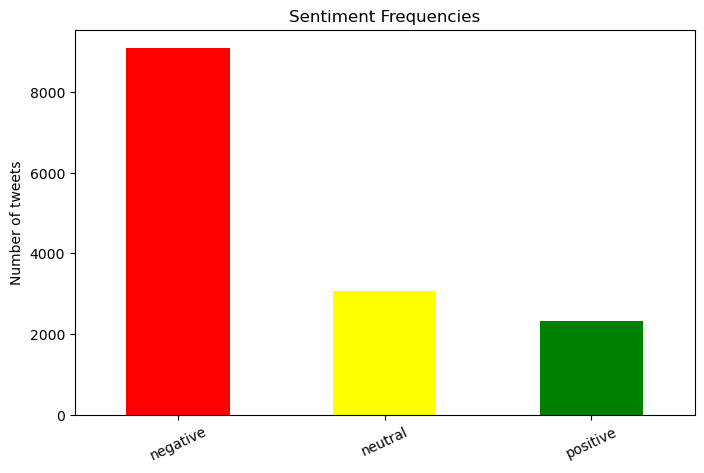

In [9]:
sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Frequencies')
plt.ylabel('Number of tweets')
plt.xticks(rotation=25)
plt.show()

In [10]:
for sentiment, count in sentiment_counts.items():
    print(f"There are {count} tweets with {sentiment} sentiment.")

There are 9082 tweets with negative sentiment.
There are 3069 tweets with neutral sentiment.
There are 2334 tweets with positive sentiment.


As we see, there are a lot of negative tweets about airlines, I think it's pretty normal as people are mostlikely going to say something when it's bad then when it's good. When it's good, it's "normal" for the passenger and doesn't require to say anything about it. But when it's really really good, they are going to say it. It's called the negativity bias (tendency for humans to pay more attention to negative events or experiences compared to positive ones).

#### 1.4 - Frequencies of negative sentiment by Airlines

For fun, let's see which company has the most negative tweets.

In [11]:
sentiment_by_company = df.groupby(['airline', 'airline_sentiment']).size().unstack()

sentiment_by_company

airline_sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


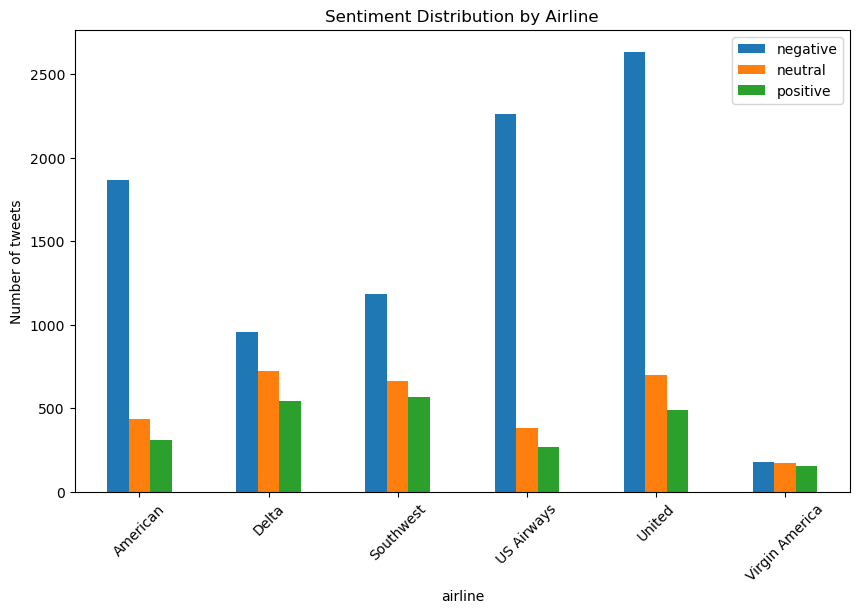

In [12]:
sentiment_by_company.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Sentiment Distribution by Airline')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [13]:
number_of_negative_tweets_by_company = sentiment_by_company["negative"]
total_tweets_by_company = sentiment_by_company.sum(axis=1)
negative_tweet_rate = (number_of_negative_tweets_by_company / total_tweets_by_company).sort_values(ascending=False)

print("Rate of Negative Tweets by Companies:")
print(negative_tweet_rate)

Rate of Negative Tweets by Companies:
airline
US Airways        0.776862
American          0.715822
United            0.688906
Southwest         0.490083
Delta             0.429793
Virgin America    0.359127
dtype: float64


We can see that passengers seem to not like US Airways, American Airlines, United Airlines. Delta Airlines seems to be less hated. About Virgin America, we can't really say anything as there are only around 500 tweets about this company.

#### 1.5 - Length of tweets

In [14]:
negative_lengths = df[df['airline_sentiment'] == 'negative']['text'].str.len()
negative_lengths.mean()

113.93536665932614

In [15]:
negative_word_counts = df[df['airline_sentiment'] == 'negative']['text'].str.split().apply(len)
negative_word_counts.mean()

19.689385597885927

In [16]:
positive_lengths = df[df['airline_sentiment'] == 'positive']['text'].str.len()
positive_lengths.mean()

86.29134532990574

In [17]:
positive_word_counts = df[df['airline_sentiment'] == 'positive']['text'].str.split().apply(len)
positive_word_counts.mean()

14.050985432733505

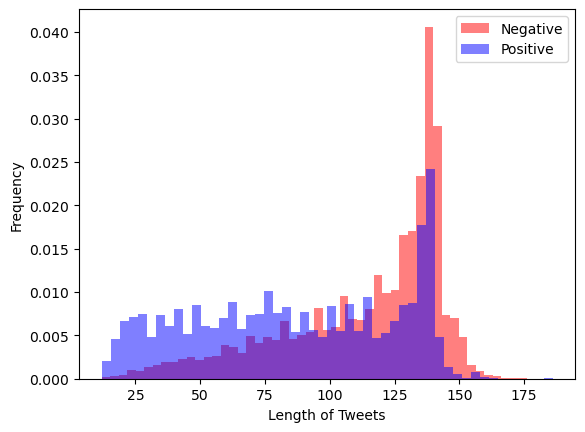

In [18]:
plt.hist(negative_lengths, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_lengths, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

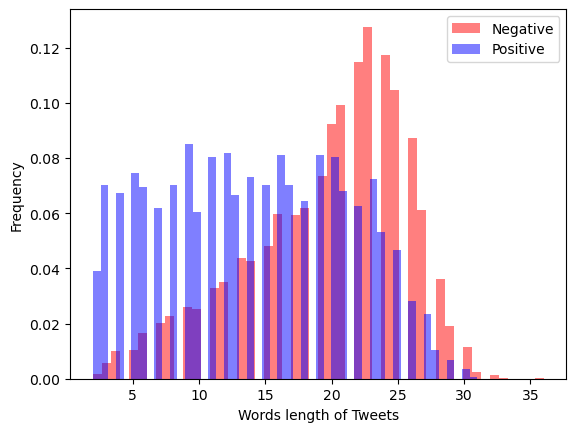

In [19]:
plt.hist(negative_word_counts, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_word_counts, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Words length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that in average, negative tweets have 20 words for 114 characters and positive tweets have 14 words for 86 characters. We may use it as a feature in our model.

# 2 - Pre-processing

#### 2.1 - Removing the useless columns

In [20]:
df = df[["text", "airline_sentiment"]]
df.head(20)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


#### 2.2 - Converting emojis

For index 18, the emoji ❤️ is important because otherwise we can't understand the analysis of just "I flying". So, now we are going to try to take care of emojis / smileys first.

In [21]:
print(emoji.demojize(df.iloc[18]["text"]))

I :red_heart: flying @VirginAmerica. :smiling_face::thumbs_up:


In [22]:
df['preprocessed_text'] = df['text'].apply(emoji.demojize)
df.head(20)

,text,airline_sentiment,preprocessed_text
0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...
5,@VirginAmerica seriously would pay $30 a fligh...,negative,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,@VirginAmerica Really missed a prime opportuni...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"@VirginAmerica it was amazing, and arrived an ..."


#### 2.3 - Tokenization and removing stopwords, symbols and company's name

In [23]:
def remove_symbols(text):
    text = text.replace("::", " ") # In case there are two emojis in a row

    # Regular expression
    pattern = r'[^a-zA-Z0-9\s]'

    # Replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

remove_symbols(df.iloc[18]["preprocessed_text"])

'I redheart flying VirginAmerica smilingface thumbsup'

In [24]:
companies = ['virginamerica', 'united', 'southwest', 'delta', 'usairways', 'americanair', 'usairway', 'southwestair']

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Tokenize the text and remove symbols
    tokens = word_tokenize(text)
    tokens = [remove_symbols(text) for text in tokens if len(remove_symbols(text)) != 0]

    # Remove stopwords and company name
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in companies]

    # Lemmatize tokens using spaCy because NLTK is not good enough if you do not precise the POS (ex: flying -> flying)
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]

    return tokens

df['preprocessed_text'] = df['preprocessed_text'].apply(preprocess_text)
df.head(20)

,text,airline_sentiment,preprocessed_text
0,@VirginAmerica What @dhepburn said.,neutral,"[dhepburn, say]"
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[not, today, must, mean, need, take, another, ..."
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta..."
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,..."
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,"[really, miss, prime, opportunity, man, withou..."
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]"


#### 2.4 - Word cloud

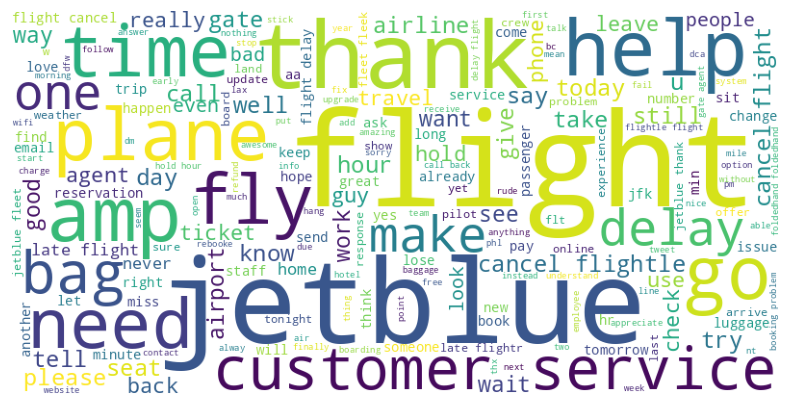

In [25]:
every_words = ' '.join(df['preprocessed_text'].explode().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(every_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

It's to check if there are not the companies' name anymore.

#### 2.5 - Length of tweets

In [26]:
df['tweet_length'] = df['text'].str.len()

df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,neutral,"[dhepburn, say]",35
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]",72
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[not, today, must, mean, need, take, another, ...",71
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
7,@VirginAmerica Really missed a prime opportuni...,neutral,"[really, miss, prime, opportunity, man, withou...",108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]",80


#### 2.6 -  Transform sentiment to numerical value

Last thing to do is to transform the label into numerical value as : negative 0, positive 1, neutral 2.

In [27]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative': 0, 'neutral': 2, 'positive': 1})
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,2,"[dhepburn, say]",35
1,@VirginAmerica plus you've added commercials t...,1,"[plus, add, commercial, experience, tacky]",72
2,@VirginAmerica I didn't today... Must mean I n...,2,"[not, today, must, mean, need, take, another, ...",71
3,@VirginAmerica it's really aggressive to blast...,0,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,0,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,0,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",1,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
7,@VirginAmerica Really missed a prime opportuni...,2,"[really, miss, prime, opportunity, man, withou...",108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",1,"[amazing, arrive, hour, early, good]",80


In [28]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(x))   # useful later for TfidfVectorizer
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,2,dhepburn say,35
1,@VirginAmerica plus you've added commercials t...,1,plus add commercial experience tacky,72
2,@VirginAmerica I didn't today... Must mean I n...,2,not today must mean need take another trip,71
3,@VirginAmerica it's really aggressive to blast...,0,really aggressive blast obnoxious entertainmen...,126
4,@VirginAmerica and it's a really big bad thing...,0,really big bad thing,55
5,@VirginAmerica seriously would pay $30 a fligh...,0,seriously would pay 30 flight seat not play re...,135
6,"@VirginAmerica yes, nearly every time I fly VX...",1,yes nearly every time fly vx ear worm go away,79
7,@VirginAmerica Really missed a prime opportuni...,2,really miss prime opportunity man without hat ...,108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1,well didntbut,47
9,"@VirginAmerica it was amazing, and arrived an ...",1,amazing arrive hour early good,80


# 3. Modelisation

In [29]:
def metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name):
    accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Accuracy of {architecture_name} on train set: {accuracy}")

    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of {architecture_name} on test set: {accuracy} \n")

    print(f"Classification Report of {architecture_name} :")
    print(classification_report(y_test, y_test_pred, zero_division=0))

#### Random Guess

In [ ]:
architecture_name = "Random Guess"

X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation
np.random.seed(42)
y_train_pred = np.random.randint(3, size=len(y_train))
y_test_pred = np.random.randint(3, size=len(y_test))

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

##### 3.1 - Always predicting negative

In [ ]:
architecture_name = "Always predicting negative"


X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation
y_train_pred = [0] * len(X_train)
y_test_pred = [0] * len(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### 3.2 - Logistic Regression with TF-IDF

In [ ]:
architecture_name = "Logistic Regression TF-IDF"

X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)



# Code before Pipeline
# # TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# X_train = tfidf_vectorizer.fit_transform(X_train)
# X_test = tfidf_vectorizer.transform(X_test)

# # Logistic Regression training
# logreg_model = LogisticRegression(max_iter=1000)
# logreg_model.fit(X_train, y_train)



# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### 3.3 - Logistic Regression with TF-IDF & tweet length

In [ ]:
architecture_name = "Logistic Regression TF-IDF & tweet length"

X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### 3.4 - Naive Bayes TF-IDF

In [ ]:
architecture_name = "Naive Bayes TF-IDF"

X = df['preprocessed_text']
y = df['airline_sentiment']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Naive Bayes with TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Naive Bayes TD-IDF & tweet length

In [ ]:
architecture_name = "Naive Bayes TF-IDF & tweet length"

X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Naive Bayes with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', MultinomialNB())
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Logistic Regression TF 2-gram

In [ ]:
architecture_name = "Logistic Regression TF 2-gram"


X = df['text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 1-gram and 2-gram
pipeline = Pipeline([
    ('tfidf', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Logistic Regression TF 2-gram + TD-IDF 4-gram + TD-IDF

In [ ]:
architecture_name = "Logistic Regression TF 2-gram + TD-IDF 4-gram + TD-IDF"


X = df[['text', 'preprocessed_text']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text')
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Pre-trained model : Distilbert finetuned on SST2

In [ ]:
architecture_name = "Distilbert finetuned on SST2"

if google_colab:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)
    X = df['text']
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load Distilbert finetuned on SST2 and its tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

    # Pre-processing the tweet
    inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

    # Pre-processing the y
    labels_test = torch.tensor(y_test.tolist()).to(device)

    # Pre-processing the dataset
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Evaluation
    model.eval()

    y_test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of {architecture_name} on test set: {accuracy} \n")

    print(f"Classification Report of {architecture_name} :")
    print(classification_report(y_test, y_test_pred, zero_division=0))

#### Pre-trained model : Distilbert finetuned on SST2 and trained on the dataset (pas possible sans virer les neutres)

In [ ]:
# architecture_name = "Distilbert finetuned on SST2 and trained on the dataset"

# if google_colab:
#     # Try the use of GPU
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using ", device)

#     X = df['text']
#     y = df['airline_sentiment']

#     # Splitting the dataset
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Load Distilbert finetuned on SST2 and its tokenizer
#     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
#     model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

#     # Pre-processing the tweet
#     inputs_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
#     inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

#     # Pre-processing the y
#     labels_train = torch.tensor(y_train.tolist()).to(device)
#     labels_test = torch.tensor(y_test.tolist()).to(device)

#     # Pre-processing the dataset
#     train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
#     train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#     test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
#     test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#     # Training
#     model.train()
#     optimizer = AdamW(model.parameters(), lr=5e-5)
#     criterion = torch.nn.CrossEntropyLoss()

#     for epoch in range(3):
#         for batch in train_loader:
#             input_ids, attention_mask, labels = [data.to(device) for data in batch]
#             optimizer.zero_grad()
#             outputs = model(input_ids, attention_mask=attention_mask)
#             loss = criterion(outputs.logits, labels)
#             loss.backward()
#             optimizer.step()

#     # Evaluation
#     model.eval()
    
#     y_train_pred = []
#     with torch.no_grad():
#         for batch in train_loader:
#             input_ids, attention_mask, labels = [data.to(device) for data in batch]  
#             outputs = model(input_ids, attention_mask=attention_mask)
#             y_train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist()) 

#     y_test_pred = []
#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids, attention_mask, labels = [data.to(device) for data in batch] 
#             outputs = model(input_ids, attention_mask=attention_mask)
#             y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())


#     accuracy = accuracy_score(y_train, y_train_pred)
#     print(f"Accuracy of {architecture_name} on train set: {accuracy}")

#     accuracy = accuracy_score(y_test, y_test_pred)
#     print(f"Accuracy of {architecture_name} on test set: {accuracy} \n")

#     print(f"Classification Report of {architecture_name} :")
#     print(classification_report(y_test, y_test_pred, zero_division=0))

##### Logistic Regression TF 2-gram + TF-IDF 4-gram + TF-IDF + Vader compound score


In [ ]:
architecture_name = "Logistic Regression TF 2-gram + TF-IDF 4-gram + TF-IDF + Vader compound score"

vader = SentimentIntensityAnalyzer()

def vader_sentiment_compound(text):
    return vader.polarity_scores(text)['compound']

df['vader_sentiment_compound'] = df['text'].apply(vader_sentiment_compound)

X = df[['text', 'preprocessed_text', 'vader_sentiment_compound']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF + Vader compound score
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('vader_sentiment_compound', 'passthrough', ['vader_sentiment_compound']),
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Logistic Regression TF 2-gram + TF-IDF 4-gram + TF-IDF + tweet length


In [ ]:
architecture_name = "Logistic Regression TF 2-gram + TF-IDF 4-gram + TF-IDF + tweet length"

X = df[['text', 'preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### VADER sentiment analysis classifier

In [ ]:
architecture_name = "VADER sentiment analysis classifier"

vader = SentimentIntensityAnalyzer()

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 1
    elif compound_score <= -0.05:
        return 0
    else: 
        return 2

df['vader_score'] = df['text'].apply(vader_sentiment_compound)

df['vader_sentiment'] = df['vader_score'].apply(classify_sentiment)


X = df['vader_sentiment']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Evaluation
y_train_pred = X_train
y_test_pred = X_test

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Random Forest TF-IDF

In [ ]:
architecture_name = "Random Forest TF-IDF"

X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with TF-IDF and Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Random Forest TF 2-gram + TF-IDF 4-gram + TF-IDF + tweet length

In [ ]:
architecture_name = "Random Forest TF 2-gram + TF-IDF 4-gram + TF-IDF + tweet length"

X = df[['text', 'preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Random Forest TF-IDF & tweet length

In [ ]:
architecture_name = "Random Forest TF-IDF & tweet length"

X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Random Forest TF-IDF 2-gram

In [ ]:
architecture_name = "Random Forest TF-IDF 2-gram"

X = df['text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 1-gram and 2-gram
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Logistic Regression presence of words

In [ ]:
architecture_name = "Logistic Regression presence of words"

X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF
pipeline = Pipeline([
    ('tfidf', CountVectorizer(binary=True)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

#### Distilbert

In [ ]:
architecture_name = "Distilbert"
google_colab = True
if google_colab:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)
    X = df['text']
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load Distilbert finetuned on SST2 and its tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)

    # Pre-processing the tweet
    inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

    # Pre-processing the y
    labels_test = torch.tensor(y_test.tolist()).to(device)

    # Pre-processing the dataset
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


    # Evaluation
    model.eval()

    y_test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of {architecture_name} on test set: {accuracy} \n")

    print(f"Classification Report of {architecture_name} :")
    print(classification_report(y_test, y_test_pred, zero_division=0))

#### Distilbert fine-tuned on the dataset

In [32]:
architecture_name = "Distilbert fine-tuned on the dataset"

if google_colab:
    # Try the use of GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)

    X = df['text']
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load Distilbert and its tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)

    # Pre-processing the tweet
    inputs_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

    # Pre-processing the y
    labels_train = torch.tensor(y_train.tolist()).to(device)
    labels_test = torch.tensor(y_test.tolist()).to(device)

    # Pre-processing the dataset
    train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Training
    model.train()

    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(3):
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_train_pred = []
    with torch.no_grad():
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    y_test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())


    metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)

Using  cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset on train set: 0.46263375906109766
Accuracy of Distilbert fine-tuned on the dataset on test set: 0.843631342768381 

Classification Report of Distilbert fine-tuned on the dataset :
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1870
           1       0.73      0.85      0.78       422
           2       0.74      0.61      0.67       605

    accuracy                           0.84      2897
   macro avg       0.79      0.79      0.79      2897
weighted avg       0.84      0.84      0.84      2897



In [31]:
architecture_name = "Distilbert fine-tuned on the dataset"
google_colab = True
if google_colab:
    # Try the use of GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)

    X = df['text']
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
    for lr in learning_rates:
        # Load Distilbert and its tokenizer
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)

        # Pre-processing the tweet
        inputs_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
        inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

        # Pre-processing the y
        labels_train = torch.tensor(y_train.tolist()).to(device)
        labels_test = torch.tensor(y_test.tolist()).to(device)

        # Pre-processing the dataset
        train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # Training
        model.train()
        
        optimizer = AdamW(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(3):
            for batch in train_loader:
                input_ids, attention_mask, labels = [data.to(device) for data in batch]
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()

        y_test_pred = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, labels = [data.to(device) for data in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())
                
        accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Accuracy of {architecture_name} with lr={lr} on test set: {accuracy} \n")

Using  cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=1e-07 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=5e-07 on test set: 0.804280289955126 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=1e-06 on test set: 0.8184328615809459 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=5e-06 on test set: 0.8405246807041767 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=1e-05 on test set: 0.8463928201587849 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=5e-05 on test set: 0.8180876769071453 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.0001 on test set: 0.8194684156023473 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.0005 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.001 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.05 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.01 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.5 on test set: 0.6454953400069037 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Distilbert fine-tuned on the dataset with lr=0.1 on test set: 0.6454953400069037 



In [39]:
architecture_name = "Bert fine-tuned on the dataset"

if google_colab:
    # Try the use of GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)

    X = df['text']
    y = df['airline_sentiment']
    
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load BERT and its tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

    # Pre-processing the tweet
    inputs_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="pt")
    inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt")

    # Pre-processing the y
    labels_train = torch.tensor(y_train.tolist())
    labels_test = torch.tensor(y_test.tolist())

    # Pre-processing the dataset
    train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Training
    model.train()
    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(3):
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_train_pred = []
    with torch.no_grad():
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    y_test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)


Using  cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of Bert fine-tuned on the dataset on train set: 0.46712115982050395
Accuracy of Bert fine-tuned on the dataset on test set: 0.8477735588539869 

Classification Report of Bert fine-tuned on the dataset :
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1870
           1       0.78      0.77      0.78       422
           2       0.73      0.63      0.68       605

    accuracy                           0.85      2897
   macro avg       0.80      0.78      0.79      2897
weighted avg       0.84      0.85      0.84      2897



In [44]:
architecture_name = "RoBERTa fine-tuned on the dataset"

if google_colab:
    # Try the use of GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using ", device)

    X = df['text']
    y = df['airline_sentiment']
    
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load BERT and its tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3).to(device)


    # Pre-processing the tweet
    inputs_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="pt")
    inputs_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt")

    # Pre-processing the y
    labels_train = torch.tensor(y_train.tolist())
    labels_test = torch.tensor(y_test.tolist())

    # Pre-processing the dataset
    train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Training
    model.train()
    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(3):
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_train_pred = []
    with torch.no_grad():
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    y_test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())

    metrics(y_train, y_train_pred, y_test, y_test_pred, architecture_name)


Using  cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy of RoBERTa fine-tuned on the dataset on train set: 0.45875043148084227
Accuracy of RoBERTa fine-tuned on the dataset on test set: 0.8581290990680014 

Classification Report of RoBERTa fine-tuned on the dataset :
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1870
           1       0.78      0.83      0.80       422
           2       0.69      0.75      0.72       605

    accuracy                           0.86      2897
   macro avg       0.80      0.83      0.81      2897
weighted avg       0.86      0.86      0.86      2897

